In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
caminho = '/content/drive/MyDrive/arquivo_final.csv'
sep =';'
data = pd.read_csv(caminho, sep=sep, dtype=float)
data = data.drop('# BlockId', axis=1)

# Filtrando os dados relacionados aos valores 1 e 2 de "voou"
data_filtered = data[data["Voo"].isin([1, 2])]

# Organizando os dados pela variável temporal (se for uma coluna com informações de data ou timestamp)
data_filtered = data_filtered.sort_values(by='Voo')

In [5]:
# Pré-processamento dos dados
# Normalização
data_normalized = (data_filtered - data_filtered.min()) / (data_filtered.max() - data_filtered.min())

# Dividindo os dados em sequências (se necessário)
sequence_length = 1  # Tamanho da sequência que será usada como entrada da RNN
sequences = []
for i in range(len(data_normalized) - sequence_length + 1):
    sequences.append(data_normalized.iloc[i:i+sequence_length+1].values)

# Convertendo os dados em arrays NumPy
#sequences = [seq.to_numpy() for seq in sequences]
#sequences = np.array(sequences)
sequences = pad_sequences(sequences, dtype='float32', padding='post')

In [6]:
# Dividindo em conjuntos de treinamento e teste
train_size = int(0.8 * len(sequences))
X_train_temporal, X_train_indices, y_train = sequences[:train_size, :-1, :-12], sequences[:train_size, :-1, -12:], sequences[:train_size, -1, -12:]

X_test_temporal, X_test_indices, y_test = sequences[train_size:, :-1, :-12], sequences[train_size:, :-1, -12:], sequences[train_size:, -1, -12:]


In [7]:
# Criando o modelo da RNN
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_temporal.shape[1], X_train_temporal.shape[2])))
model.add(Dense(32, activation='relu'))  # Camada densa para processar as informações importantes
model.add(Dense(12))  # Camada de saída com 12 neurônios para os 12 índices importantes

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(X_train_temporal, y_train, epochs=100, batch_size=16)



# Visualizando os resultados


Epoch 1/100
6/6 [==============================] - 3s 5ms/step - loss: 0.3279
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.3128
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.3009
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2880
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.2728
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2585
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 0.2391
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.2205
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1992
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1761
Epoch 11/100
6/6 [==============================] - 0s 6ms/step - loss: 0.1543
Epoch 12/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1344
Epoch 13/100
6/6 [==============================] - 0s 5ms/st

In [8]:
# Avaliando o modelo
loss = model.evaluate(X_test_temporal, y_test)
print("Erro médio quadrático no conjunto de teste:", loss)

# Fazendo previsões com o modelo treinado
predictions = model.predict(X_test_temporal)

# Desnormalizando as previsões e os valores reais
predictions = predictions * (data_filtered.iloc[:, -12:].max().values - data_filtered.iloc[:, -12:].min().values) + data_filtered.iloc[:, -12:].min().values
y_test_original = y_test * (data_filtered.iloc[:, -12:].max().values - data_filtered.iloc[:, -12:].min().values) + data_filtered.iloc[:, -12:].min().values

resultado = pd.DataFrame({
    'previsao': predictions.flatten(),
    'real': y_test_original.flatten()
})

resultado

1/1 [==============================] - 1s 757ms/step - loss: 0.0412
Erro médio quadrático no conjunto de teste: 0.04117180407047272
1/1 [==============================] - 1s 698ms/step


,previsao,real
0,0.375422,0.351939
1,0.418698,0.429426
2,0.454361,0.431787
3,0.461102,0.452206
4,0.588770,0.576545
...,...,...
259,0.804996,-0.006833
260,0.526331,0.387305
261,0.524398,0.463878
262,0.848339,0.070738


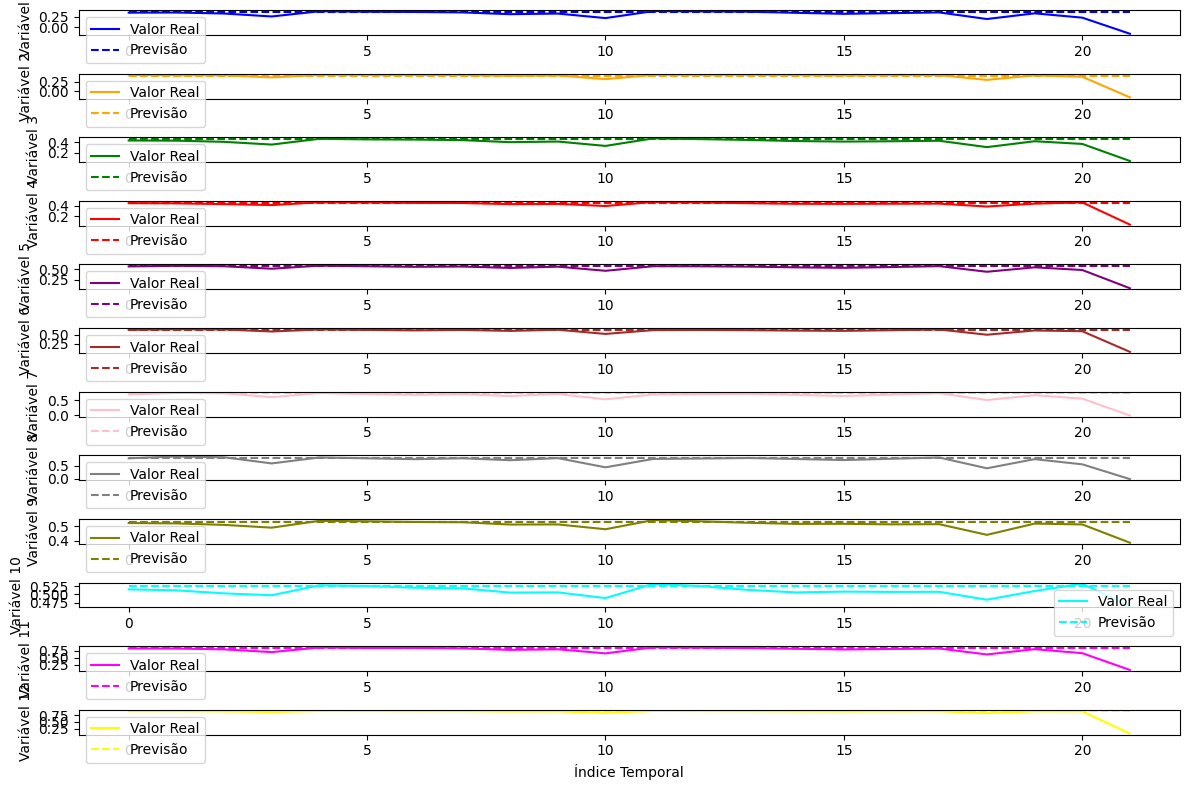

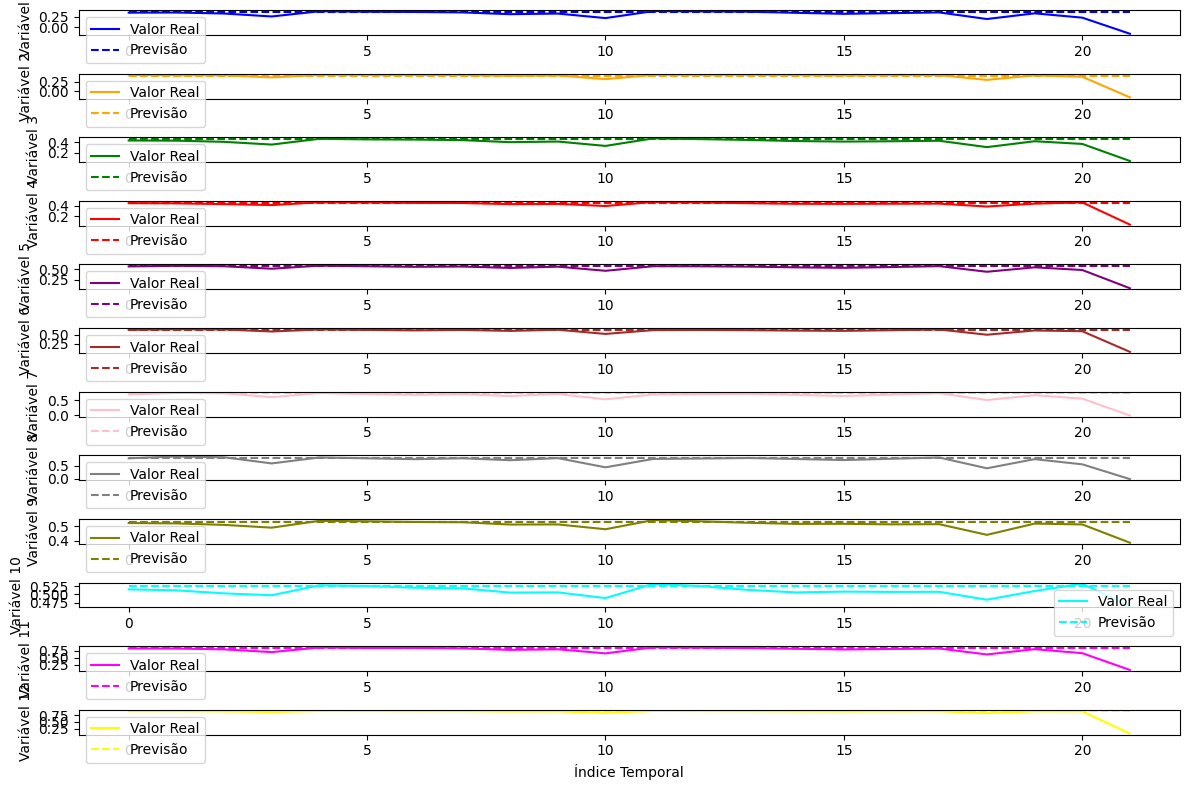

In [9]:
# Visualizando os resultados
plt.figure(figsize=(12, 8))

# Número de variáveis a serem plotadas
num_variables = y_test_original.shape[1]

# Cores para os plots
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']

for i in range(num_variables):
    plt.subplot(num_variables, 1, i+1)
    plt.plot(y_test_original[:, i], label=f'Valor Real', color=colors[i])
    plt.plot(predictions[:, i], label=f'Previsão', color=colors[i], linestyle='dashed')
    plt.ylabel(f'Variável {i+1}')
    if i == num_variables - 1:
        plt.xlabel('Índice Temporal')
    plt.legend()

plt.tight_layout()
plt.show()
# Visualizando os resultados
plt.figure(figsize=(12, 8))

# Número de variáveis a serem plotadas
num_variables = y_test_original.shape[1]

# Cores para os plots
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow']

for i in range(num_variables):
    plt.subplot(num_variables, 1, i+1)
    plt.plot(y_test_original[:, i], label=f'Valor Real', color=colors[i])
    plt.plot(predictions[:, i], label=f'Previsão', color=colors[i], linestyle='dashed')
    plt.ylabel(f'Variável {i+1}')
    if i == num_variables - 1:
        plt.xlabel('Índice Temporal')
    plt.legend()

plt.tight_layout()
plt.show()
